# Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import shapiro
import statistics

# Чтение файла

In [2]:
df = pd.read_csv('data.csv', delimiter=';')
df

,date,lvl_5,card_id,checks
0,2022-01-01,ВИНО АРОМАТИЗИРОВАННОЕ,3338,1
1,2022-01-01,ВИНО АРОМАТИЗИРОВАННОЕ,3988,1
2,2022-01-01,ВИНО АРОМАТИЗИРОВАННОЕ,12237,1
3,2022-01-01,ВИНО АРОМАТИЗИРОВАННОЕ,14576,1
4,2022-01-01,ВИНО АРОМАТИЗИРОВАННОЕ,18316,1
...,...,...,...,...
474163,2023-01-01,ШАМПАНСКИЕ И ИГРИСТЫЕ,982233653,1
474164,2023-01-01,ШАМПАНСКИЕ И ИГРИСТЫЕ,982296880,8
474165,2023-01-01,ШАМПАНСКИЕ И ИГРИСТЫЕ,992121889,6
474166,2023-01-01,ШАМПАНСКИЕ И ИГРИСТЫЕ,992211561,4


# Предпросмотр данных

Переименуем поле "номенклатуры" на более удобное

In [3]:
df.rename(columns={'lvl_5': 'name'}, inplace=True)

Смотрим количество пропущенных значений

In [4]:
df.isna().sum()

date       0
name       0
card_id    0
checks     0
dtype: int64

Убедимся, что в данных действительно есть клиенты, которые совершают разные покупки

In [5]:
df[df.duplicated('card_id')].head(5)

,date,name,card_id,checks
302,2022-01-01,ВИНО БЕЛОЕ,12237,4
343,2022-01-01,ВИНО БЕЛОЕ,42781,1
357,2022-01-01,ВИНО БЕЛОЕ,58235,4
381,2022-01-01,ВИНО БЕЛОЕ,87546,2
441,2022-01-01,ВИНО БЕЛОЕ,164286,1


Посмотрим данные одного из таких клиентов

In [6]:
df[df['card_id'] == 12237].head(5)

,date,name,card_id,checks
2,2022-01-01,ВИНО АРОМАТИЗИРОВАННОЕ,12237,1
302,2022-01-01,ВИНО БЕЛОЕ,12237,4
11679,2022-01-01,"КОНЬЯК, БРЕНДИ РОССИЯ",12237,1
12307,2022-01-01,НАПИТКИ Б/А 1Л И БОЛЕЕ,12237,1
15368,2022-01-01,НАПИТКИ Б/А МЕНЕЕ 1 Л,12237,1


Посмотрим на все имеющиеся даты

In [7]:
df['date'].unique()

array(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
       '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
       '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
       '2023-01-01'], dtype=object)

Данные предоставлены за период "2022-01-01" - "2023-01-01", каждая дата представляет из себя 01 число каждого из месяцев

Посмотрим уникальные значения номенклатуры

In [8]:
print('Количество уникальных значений: ' + str(df['name'].nunique()))
df['name'].unique()

Количество уникальных значений: 31


array(['ВИНО АРОМАТИЗИРОВАННОЕ', 'ВИНО БЕЛОЕ', 'ВИНО БЭГ-ИН-БОКС/ТЕТРАП.',
       'ВИНО КРАСНОЕ', 'ВИНО КРЕПЛЕНОЕ, КАГОР', 'ВИНО ПЛОДОВЫЕ',
       'ВИНО РОЗОВЫЕ', 'ВИСКИ', 'ВОДА 1Л И БОЛЕЕ', 'ВОДА МЕНЕЕ 1 ЛИТРА',
       'ВОДКА ОБЫКНОВЕННАЯ', 'ВОДКА ОСОБАЯ',
       'ГАЗИРОВАННЫЙ ВИННЫЙ НАПИТОК', 'ДИСТИЛЛЯТЫ ПРОЧИЕ',
       'ИМП. КОНЬЯК, БРЕНДИ, АРМАНЬЯК', 'КОНЬЯК, БРЕНДИ РОССИЯ',
       'ЛИКЕРЫ, БАЛЬЗАМЫ', 'НАПИТКИ Б/А 1Л И БОЛЕЕ',
       'НАПИТКИ Б/А МЕНЕЕ 1 Л', 'НАСТОЙКИ', 'ПИВО БОЛЕЕ 1 ЛИТРА',
       'ПИВО ДО 1 ЛИТРА', 'ПРЕДМЕТЫ ДЛЯ КУРЕНИЯ', 'РАЗЛИВНЫЕ НАПИТКИ',
       'СИГАРЕТЫ', 'СИРОПЫ И ФРУКТ. НАПИТКИ', 'СЛАБЫЙ АЛКОГОЛЬ',
       'СОКИ И НЕКТАРЫ 1 Л И МЕНЕЕ', 'СОКИ И НЕКТАРЫ В ИНД УПАКОВКЕ',
       'СОКИ И НЕКТАРЫ СВЫШЕ 1 Л.', 'ШАМПАНСКИЕ И ИГРИСТЫЕ'], dtype=object)

# Предобработка данных

In [9]:
# преобразуем поле date в формат даты
df['date'] = pd.to_datetime(df['date'])

# определим дату покупки для каждой позиции номенклатуры
df['month'] = df['date'].dt.to_period('M')
first_buy = df.groupby('name')['month'].min().reset_index()
first_buy.columns = ['name', 'first_buy_month']

# добавим данные о первой покупке номенклатуры в исходный датасет
df = pd.merge(df, first_buy, on='name', how='left')

# найдем уникальные даты первой покупки номенклатуры
df['first_buy_month'].unique()

<PeriodArray>
['2022-01']
Length: 1, dtype: period[M]

Каждый товар имеет дату первой покупки "2022-01-01", значит на графике когоротного анализа будут заполнены все ячейки

In [10]:
# сагреригуем данные
cohort_data = df.groupby(['first_buy_month', 'month', 'name']).agg(n_checks=('checks', 'sum')).reset_index()

# создадим сводную таблицу для каждой позиции номенклатуры
cohort_data['period'] = (cohort_data['month'] - cohort_data['first_buy_month']).apply(lambda x: x.n)
cohort_pivot = cohort_data.pivot_table(index=['name', 'first_buy_month'], columns='period', values='n_checks', aggfunc='sum')
cohort_pivot.head(5)

,period,0,1,2,3,4,5,6,7,8,9,10,11,12
name,first_buy_month,,,,,,,,,,,,,
ВИНО АРОМАТИЗИРОВАННОЕ,2022-01,451,223,379,165,222,426,237,187,238,267,402,1229,422
ВИНО БЕЛОЕ,2022-01,1888,1889,5398,2038,2276,2645,3053,4443,2829,2900,2602,3787,2593
ВИНО БЭГ-ИН-БОКС/ТЕТРАП.,2022-01,484,417,547,599,741,808,682,990,658,562,806,683,1177
ВИНО КРАСНОЕ,2022-01,2358,2412,6125,2288,2309,2516,2562,3574,2900,3233,3034,3694,2276
"ВИНО КРЕПЛЕНОЕ, КАГОР",2022-01,35,47,84,207,84,39,30,68,91,73,80,71,95


# Визуализация

In [11]:
# функция для построения графика
def showplot():
    product_names = list(df['name'].unique())
    product_cohorts = [cohort_pivot.loc[name] for name in product_names]
    months = ['янв.', 'фев.', 'март', 'апр.', 'май', 'июнь', 'июль', 'авг.', 'сен.', 'окт.', 'нояб.', 'дек.']

    fig, axs = plt.subplots(nrows=df['name'].nunique(), figsize=(12, 23), gridspec_kw={'hspace': 0})
    fig.suptitle('Когортный анализ', fontsize=24, y=0.97)

    for i, product_cohort in enumerate(product_cohorts):
        sns.heatmap(product_cohort, annot=True, fmt='.0f', cmap='Blues', ax=axs[i], cbar=False)
        axs[i].set_ylabel(f'{product_names[i]}', labelpad=10, rotation=0, ha='left')
        axs[i].yaxis.set_label_coords(-0.3, 0.4)
        axs[i].tick_params(axis='y', labelleft=False)
        xticks_labels = [months[int(label) % 12] for label in product_cohort.columns]
        axs[i].set_xticklabels(xticks_labels, rotation=0)

    plt.xlabel('Месяц', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Построим график

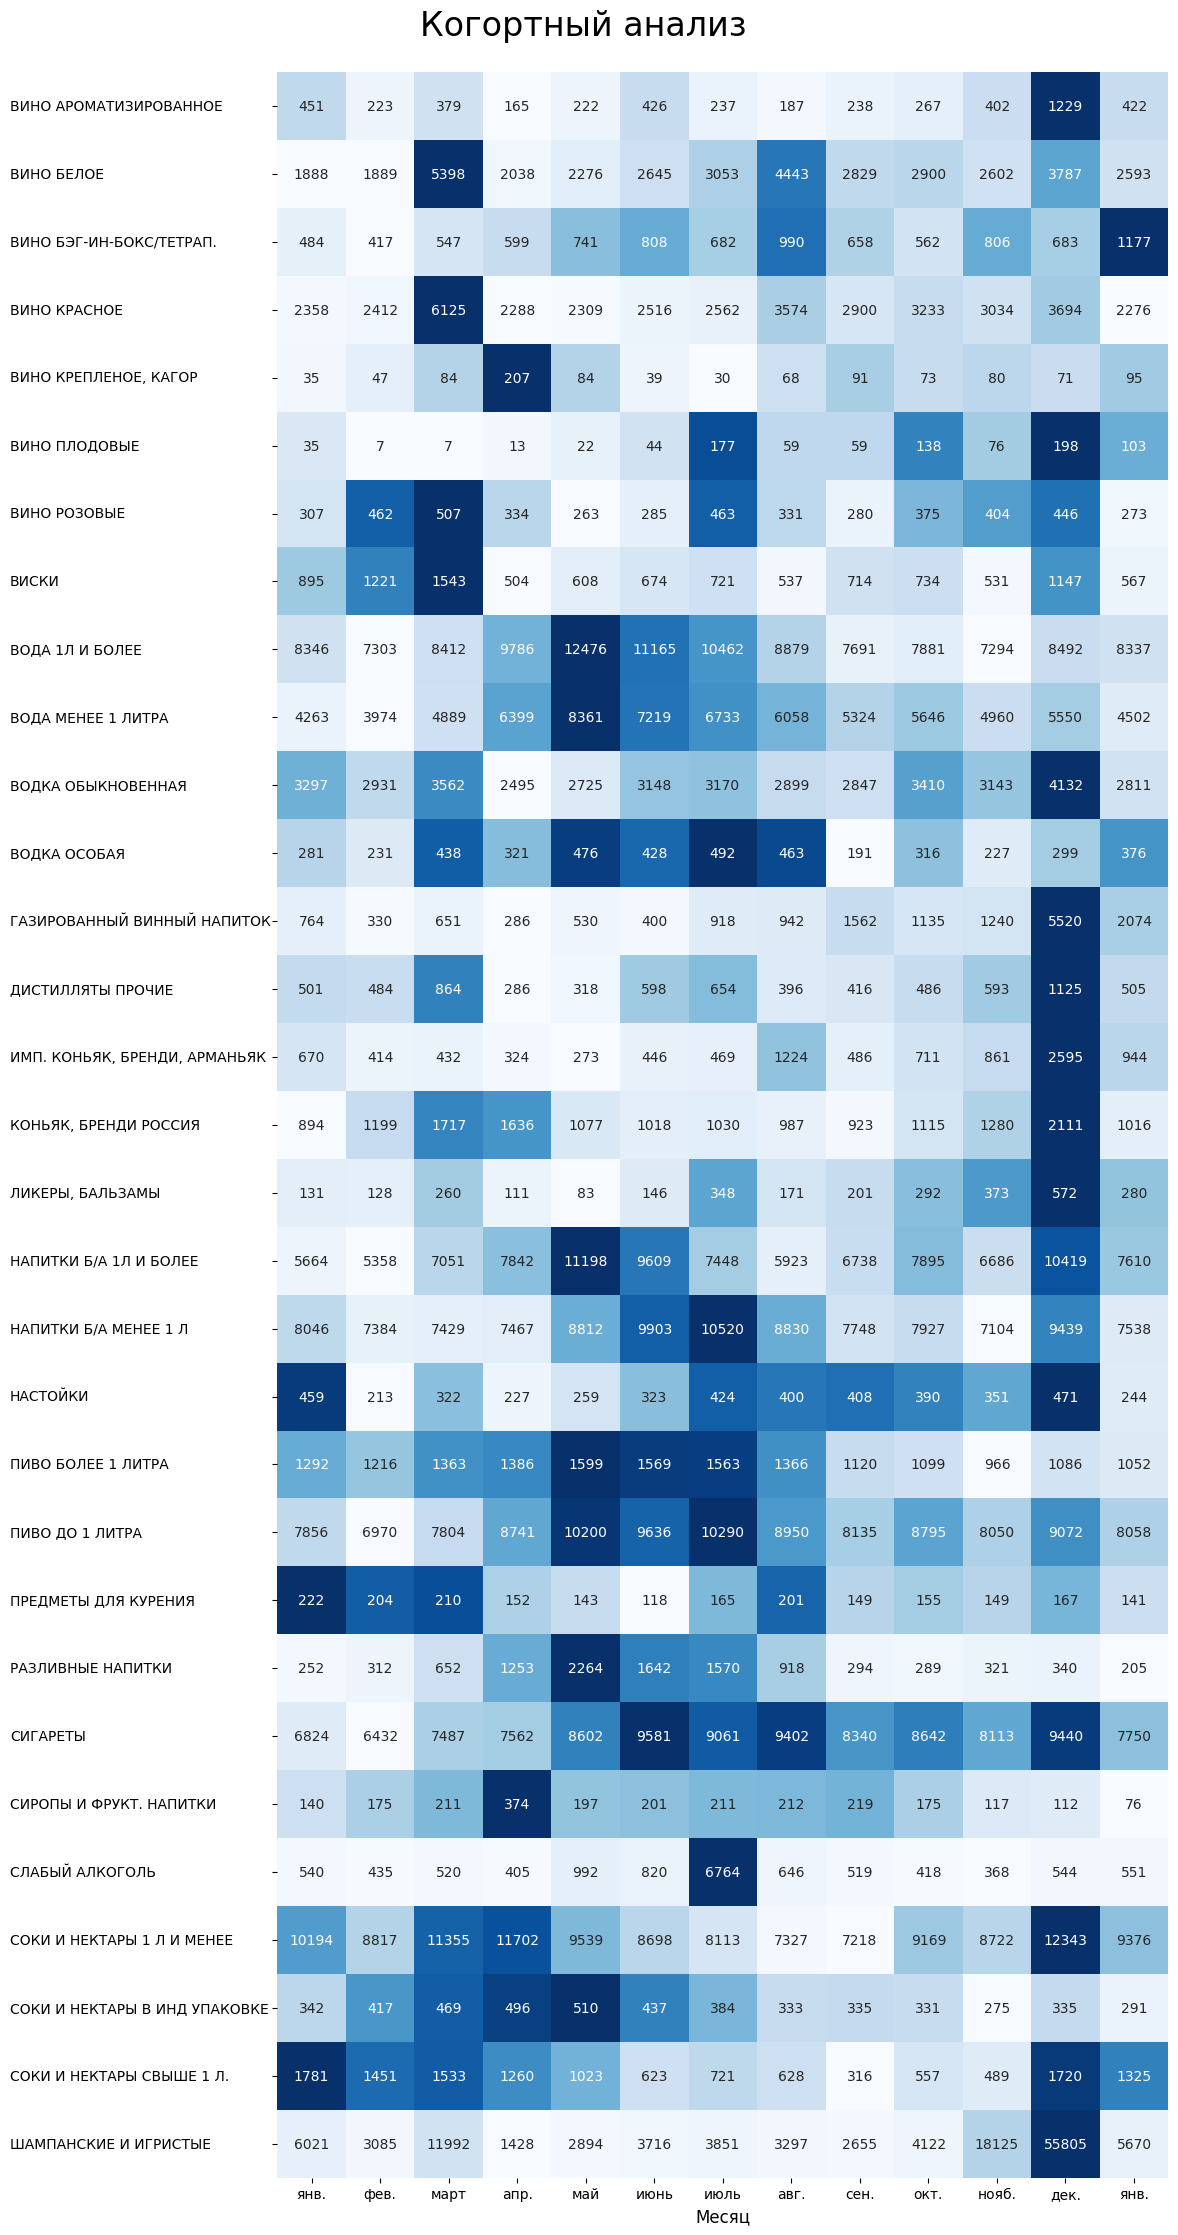

In [12]:
showplot()

Предварительные выводы по графику:

- популярность товара со временем не снижается
- популярность товара имеет сезонность (некоторые товары покупаются чаще в определенные месяцы года)

# Проанализируем товары на сезонность

Посмотрим на товар с явно выраженной летней сезонностью - "СЛАБЫЙ АЛКОГОЛЬ"

In [13]:
cohort_pivot.loc['СЛАБЫЙ АЛКОГОЛЬ']

period,0,1,2,3,4,5,6,7,8,9,10,11,12
first_buy_month,,,,,,,,,,,,,
2022-01,540,435,520,405,992,820,6764,646,519,418,368,544,551


Предположим, что товары с сезонностью имеют подобие нормального распределения с пиком в центре и симметричными боковыми сторонами. Проверим гипотезу о нормальности распределения, используя тест Шапиро-Уилка

In [14]:
stat, p = shapiro(cohort_pivot.loc['СЛАБЫЙ АЛКОГОЛЬ'])

if p > 0.05:
    print("Товар имеет нормальное распределение")
else:
    print("Товар НЕ имеет нормальное распределение")

Товар НЕ имеет нормальное распределение


В таком случае для определения сезонности товара будем использовать следующий критерий: если все три месяца в середине распределения имеют значения больше медианы, то такой товар будем считать сезонным

In [15]:
# функция для проверки сезонности товара
def distribution_test(row):
    median = statistics.median(row)
    if sum(row[4:7]) > median*3:
        return 1
    else:
        return 0

Определим список номенклатуры, подходящий под данный критерий. Поскольку сейчас месяцы идут по порядку от 1 до 12, середина распределения приходится на "летний" период

In [16]:
cohort_pivot['summer'] = cohort_pivot.apply(distribution_test, axis=1)
cohort_summer = cohort_pivot[cohort_pivot['summer'] == 1]
cohort_summer

,period,0,1,2,3,4,5,6,7,8,9,10,11,12,summer
name,first_buy_month,,,,,,,,,,,,,,
ВИНО АРОМАТИЗИРОВАННОЕ,2022-01,451,223,379,165,222,426,237,187,238,267,402,1229,422,1
ВИНО БЕЛОЕ,2022-01,1888,1889,5398,2038,2276,2645,3053,4443,2829,2900,2602,3787,2593,1
ВИНО БЭГ-ИН-БОКС/ТЕТРАП.,2022-01,484,417,547,599,741,808,682,990,658,562,806,683,1177,1
ВИНО ПЛОДОВЫЕ,2022-01,35,7,7,13,22,44,177,59,59,138,76,198,103,1
ВИНО РОЗОВЫЕ,2022-01,307,462,507,334,263,285,463,331,280,375,404,446,273,1
ВОДА 1Л И БОЛЕЕ,2022-01,8346,7303,8412,9786,12476,11165,10462,8879,7691,7881,7294,8492,8337,1
ВОДА МЕНЕЕ 1 ЛИТРА,2022-01,4263,3974,4889,6399,8361,7219,6733,6058,5324,5646,4960,5550,4502,1
ВОДКА ОСОБАЯ,2022-01,281,231,438,321,476,428,492,463,191,316,227,299,376,1
ДИСТИЛЛЯТЫ ПРОЧИЕ,2022-01,501,484,864,286,318,598,654,396,416,486,593,1125,505,1


Определим список номенклатуры, имеющий "зимнюю" сезонность

In [17]:
# удалим столбец с летней сезонностью
cohort_pivot = cohort_pivot.drop('summer', axis=1)

# удалим столбец с январем 2022 года, тк январь 2022 и январь 2023 дублируют друг друга (в разрезе определения сезонности)
cohort_pivot = cohort_pivot.iloc[:, 1:]

# поменяем столбцы местами таким образом, чтобы зимние месяца оказались в середине распределения
for i in range(1, 6):
    cohort_pivot[f'{i}'] = cohort_pivot.iloc[:, 0:1]
    cohort_pivot = cohort_pivot.iloc[:, 1:]

# проверим получившийся датасет
cohort_pivot.head(1)

,period,6,7,8,9,10,11,12,1,2,3,4,5
name,first_buy_month,,,,,,,,,,,,
ВИНО АРОМАТИЗИРОВАННОЕ,2022-01,237,187,238,267,402,1229,422,223,379,165,222,426


In [18]:
cohort_pivot['winter'] = cohort_pivot.apply(distribution_test, axis=1)
cohort_winter = cohort_pivot[cohort_pivot['winter'] == 1]
cohort_winter

,period,6,7,8,9,10,11,12,1,2,3,4,5,winter
name,first_buy_month,,,,,,,,,,,,,
ВИНО АРОМАТИЗИРОВАННОЕ,2022-01,237,187,238,267,402,1229,422,223,379,165,222,426,1
ВИНО БЕЛОЕ,2022-01,3053,4443,2829,2900,2602,3787,2593,1889,5398,2038,2276,2645,1
ВИНО БЭГ-ИН-БОКС/ТЕТРАП.,2022-01,682,990,658,562,806,683,1177,417,547,599,741,808,1
ВИНО КРАСНОЕ,2022-01,2562,3574,2900,3233,3034,3694,2276,2412,6125,2288,2309,2516,1
"ВИНО КРЕПЛЕНОЕ, КАГОР",2022-01,30,68,91,73,80,71,95,47,84,207,84,39,1
ВИНО ПЛОДОВЫЕ,2022-01,177,59,59,138,76,198,103,7,7,13,22,44,1
ВИНО РОЗОВЫЕ,2022-01,463,331,280,375,404,446,273,462,507,334,263,285,1
ВИСКИ,2022-01,721,537,714,734,531,1147,567,1221,1543,504,608,674,1
ВОДКА ОБЫКНОВЕННАЯ,2022-01,3170,2899,2847,3410,3143,4132,2811,2931,3562,2495,2725,3148,1


Сохраним полученные значения в списки

In [19]:
summer_products = cohort_summer.index.get_level_values(0).tolist()
winter_products = cohort_winter.index.get_level_values(0).tolist()

# Результат

In [20]:
print('Список номенклатуры с "летней" сезонностью:')
print()

for i in summer_products:
    print(i)

Список номенклатуры с "летней" сезонностью:

ВИНО АРОМАТИЗИРОВАННОЕ
ВИНО БЕЛОЕ
ВИНО БЭГ-ИН-БОКС/ТЕТРАП.
ВИНО ПЛОДОВЫЕ
ВИНО РОЗОВЫЕ
ВОДА 1Л И БОЛЕЕ
ВОДА МЕНЕЕ 1 ЛИТРА
ВОДКА ОСОБАЯ
ДИСТИЛЛЯТЫ ПРОЧИЕ
НАПИТКИ Б/А 1Л И БОЛЕЕ
НАПИТКИ Б/А МЕНЕЕ 1 Л
ПИВО БОЛЕЕ 1 ЛИТРА
ПИВО ДО 1 ЛИТРА
РАЗЛИВНЫЕ НАПИТКИ
СИГАРЕТЫ
СИРОПЫ И ФРУКТ. НАПИТКИ
СЛАБЫЙ АЛКОГОЛЬ
СОКИ И НЕКТАРЫ В ИНД УПАКОВКЕ


In [21]:
print('Список номенклатуры с "зимней" сезонностью:')
print()

for i in winter_products:
    print(i)

Список номенклатуры с "зимней" сезонностью:

ВИНО АРОМАТИЗИРОВАННОЕ
ВИНО БЕЛОЕ
ВИНО БЭГ-ИН-БОКС/ТЕТРАП.
ВИНО КРАСНОЕ
ВИНО КРЕПЛЕНОЕ, КАГОР
ВИНО ПЛОДОВЫЕ
ВИНО РОЗОВЫЕ
ВИСКИ
ВОДКА ОБЫКНОВЕННАЯ
ГАЗИРОВАННЫЙ ВИННЫЙ НАПИТОК
ДИСТИЛЛЯТЫ ПРОЧИЕ
ИМП. КОНЬЯК, БРЕНДИ, АРМАНЬЯК
КОНЬЯК, БРЕНДИ РОССИЯ
ЛИКЕРЫ, БАЛЬЗАМЫ
НАПИТКИ Б/А 1Л И БОЛЕЕ
НАПИТКИ Б/А МЕНЕЕ 1 Л
НАСТОЙКИ
СОКИ И НЕКТАРЫ 1 Л И МЕНЕЕ
СОКИ И НЕКТАРЫ СВЫШЕ 1 Л.
ШАМПАНСКИЕ И ИГРИСТЫЕ


In [22]:
multiseason_products = list(set(summer_products) & set(winter_products))
multiseason_products.sort()

print('Список номенклатуры с двойной ("летняя" + "зимняя") сезонностью:')
print()

for i in multiseason_products:
    print(i)

Список номенклатуры с двойной ("летняя" + "зимняя") сезонностью:

ВИНО АРОМАТИЗИРОВАННОЕ
ВИНО БЕЛОЕ
ВИНО БЭГ-ИН-БОКС/ТЕТРАП.
ВИНО ПЛОДОВЫЕ
ВИНО РОЗОВЫЕ
ДИСТИЛЛЯТЫ ПРОЧИЕ
НАПИТКИ Б/А 1Л И БОЛЕЕ
НАПИТКИ Б/А МЕНЕЕ 1 Л


# Вывод

На основании предоставленных данных:
- был проведен когортный анализ номенклатуры
- определено, что популярность товара не снижается со временем и имеет сезонность
- составлены списки номенклатуры с "летней" и "зимней" сезонностью
- составлен список номенклатуры, имеющей двойную ("летнюю" + "зимнюю") сезонность